![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/soilmechanics

# A simple monolithic thermo-poro-elastic MFront model

The constitutive content of the MFront file is not complete. Some quantities remain to be calculated by OGS MPL.

**List of drivers/gradients**

* Temperature $T$ is treated automatically as an external state variable
* Temperature gradient $\nabla T$
* Liquid pressure gradient $\nabla p_\text{LR}$
* Capillary pressure $p_\text{cap}$
* Strain tensor $\boldsymbol\epsilon$

**Calculated quantities / fluxes / forces**

Total stress

\begin{align*}
    \boldsymbol \sigma &= \boldsymbol{\sigma}' - \alpha_\text{B} \chi(S_\text{L}) p_\text{LR} \mathbf{I}
    \\
    \text{with}&
    \\
    \boldsymbol{\sigma}' &= {}^t \boldsymbol{\sigma}' + K\,\text{tr}\,(\Delta \boldsymbol\epsilon - \alpha_{T\text{S}} \Delta T \mathbf{I}) \,\mathbf{I} + 2 \mu \Delta \boldsymbol\epsilon^\text{D}
    \\
    \chi(S_\text{L}) &= S_\text{L}^{m_\chi}
    \\
    S_\text{L} &= \dots
\end{align*}

Liquid density

\begin{align}
    \varrho_\text{LR} &= \varrho_0 \left[ 1 + \beta_p (p_\text{LR} - p_\text{LR}^\text{ref}) - \beta_T (T - T^\text{ref}) \right]
\end{align}

Darcy flux

\begin{align}
    \tilde{\mathbf{w}}_\text{LS} &= - \frac{\mathbf{k} k_\text{LR}(S_\text{L})}{\mu_\text{LR}} \left( \text{grad} p_\text{LR} - \varrho_\text{LR} \mathbf{g} \right)
    \\
    \text{with}&
    \\
    k_\text{LR}(S_\text{L}) &= \dots
\end{align}

Conductive Heat flux

\begin{align}
    \mathbf{q}_\text{th} &= - \boldsymbol\lambda_\text{eff}\, \text{grad}T
    \\
    \text{with}&
    \\
    \boldsymbol\lambda_\text{eff} &= \dots
\end{align}

This can be extended towards heat capacity, advection transport, etc.

For the full formulation see our Overleaf.

## Simplified version -- only stress calculation

For a first trial run in OGS we use the following reduced model. The idea is to switch the weak momentum balance to a total stress formulation. The important change is the following term which contains no more reference to the effective stress principle:

\begin{align}
    r_u &\mathrel{+}= \int \limits_\Omega { \boldsymbol{\sigma} \mathbf{:} \text{grad} \mathbf{v}_u }\,\text{d}\Omega
\end{align}

\textbf{Linearization} can now proceed in a general fashion.

\begin{align}
    \text{D}_{\Delta u} r_u &\mathrel{+}= \int \limits_\Omega {\left[ \text{grad} \mathbf{v}_u \mathbf{:} \frac{\partial \boldsymbol{\sigma}}{\partial \boldsymbol{\epsilon}} \mathbf{:} \Delta \boldsymbol{\epsilon} \right]}\,\text{d}\Omega \quad \text{with  } \Delta \boldsymbol{\epsilon} = \text{sym grad}\Delta \mathbf{u}
    \\
    \text{D}_{\Delta p} r_u &\mathrel{+}= \int \limits_\Omega{\left[ \text{grad} \mathbf{v}_u \mathbf{:} \frac{\partial \boldsymbol{\sigma}}{\partial p_\text{LR}} \Delta p_\text{LR} \right]}\,\text{d}\Omega
    \\
    \text{D}_{\Delta T} r_u &\mathrel{+}= \int \limits_\Omega{\left[ \text{grad} \mathbf{v}_u \mathbf{:} \frac{\partial \boldsymbol{\sigma}}{\partial T} \Delta T \right]}\,\text{d}\Omega
\end{align}

This leads to a reduced 

**List of drivers/gradients**

* Temperature $T$ is treated automatically as an external state variable
* Liquid pressure $p_\text{LR}$
* Strain tensor $\boldsymbol\epsilon$

Our model then computes the following

**Fluxes/forces/states**

Total stress

\begin{align*}
    \boldsymbol \sigma &= \boldsymbol{\sigma}' - \alpha_\text{B} \chi(S_\text{L}) p_\text{LR} \mathbf{I}
    \\\\
    \text{with}&
    \\
    \boldsymbol{\sigma}' &= {}^t \boldsymbol{\sigma}' + K\,\text{tr}\,(\Delta \boldsymbol\epsilon - \alpha_{T\text{S}} \Delta T \mathbf{I}) \,\mathbf{I} + 2 \mu \Delta \boldsymbol\epsilon^\text{D}
    \\
    \chi(S_\text{L}) &= S_\text{L}^{m_\chi}
    \\
    S_\text{L}(p_\text{cap} = -p_\text{LR}) &= \dots
\end{align*}

where Richards was assumed. Note also that all these derivatives are explicit and no iteration is required.

The following derivatives required in the weak form Jacobian are then specified

\begin{align}
    \frac{\partial \boldsymbol{\sigma}}{\partial \boldsymbol{\epsilon}} &= \frac{\partial \boldsymbol{\sigma}'}{\partial \Delta \boldsymbol{\epsilon}_\text{el}} = \lambda \mathbf{I} \otimes \mathbf{I} + 2\mu \mathbf{I}\odot\mathbf{I}
    \\
    \frac{\partial \boldsymbol{\sigma}}{\partial p_\text{LR}} &= -\alpha_\text{B} \left( \chi(S_\text{L}) - m_\chi S_\text{L}^{m_\chi -1} \frac{\partial S_\text{L}}{\partial p_\text{cap}} p_\text{LR} \right) \mathbf{I}
    \\
    \frac{\partial \boldsymbol{\sigma}}{\partial T} &= - 3 K \alpha_{T\text{S}}\mathbf{I} 
\end{align}

In [1]:
#HIDDEN
import mtest
import tfel.tests
import numpy as np
import matplotlib.pyplot as plt
import os
import plot_settings
mtest.setVerboseMode(mtest.VerboseLevel.VERBOSE_QUIET)

In [2]:
#HIDDEN
#os.system('mfront --obuild --interface=generic ThermoPoroElasticity.mfront')

In [3]:
#HIDDEN
def isochoric_drained_heating(external_MTest = False):
    if external_MTest:
        os.system('mtest ThermoPoroElasticity.mtest')
    else:
        m    = mtest.MTest()
        m.setMaximumNumberOfSubSteps(1)
        m.setBehaviour('generic', './src/libBehaviour.so', 'ThermoPoroElasticity')
        m.setGradientsInitialValues([0, 0, 0, 0, 0, 0, 0])
        m.setThermodynamicForcesInitialValues([-1e5,-1e5,-1e5, 0, 0, 0, 1.0])
        m.setImposedGradient('StrainXX', 0)
        m.setImposedGradient('StrainYY', 0)
        m.setImposedGradient('StrainZZ', 0)
        m.setImposedGradient('StrainXY', 0)
        m.setImposedGradient('StrainXZ', 0)
        m.setImposedGradient('StrainYZ', 0)
        m.setImposedGradient('LiquidPressure', 0)
        m.setExternalStateVariable('Temperature', {0:293, 1:333})

        m.setMaterialProperty('YoungModulus', 10e9)
        m.setMaterialProperty('PoissonRatio', 0.3)
        m.setMaterialProperty('ThermalExpansion', 1e-5)
        m.setMaterialProperty('BiotCoefficient', 1.0)
        m.setMaterialProperty('BishopsExponent', 1.0)
        m.setMaterialProperty('ResidualLiquidSaturation', 0.0)
        m.setMaterialProperty('ResidualGasSaturation', 0.0)
        m.setMaterialProperty('BubblePressure', 5e5)
        m.setMaterialProperty('VanGenuchtenExponent_m', 2.4)

        output_file = 'isochoric_drained_heating.res'
        m.setOutputFileName(output_file)
        m.setTimes(list(np.linspace(0,1,11)))
        m.execute()

In [4]:
isochoric_drained_heating()

In [5]:
output_file = 'isochoric_drained_heating.res'
results = np.loadtxt(output_file).T

In [6]:
#Expected solution. Quick&Dirty, attention if test is changed
E = 10e9
nu = 0.3
alphaTS = 1e-5
dT = 40
p_eff = 3 * E/(3*(1-2*nu)) * alphaTS * dT

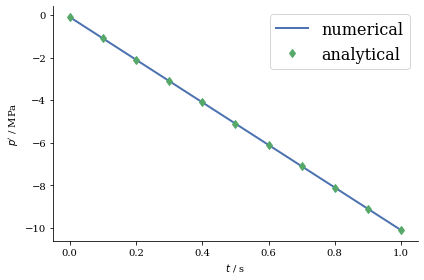

In [7]:
fig, ax = plt.subplots()
ax.plot(results[0],results[8]/1e6,label='numerical')
ax.plot(results[0],(-p_eff*results[0]-1e5)/1e6,label='analytical',marker='d',ls='')
ax.legend();
ax.set_xlabel('$t$ / s')
ax.set_ylabel("$p'$ / MPa")
fig.tight_layout();

In [8]:
def uniaxial_isothermal_drainage_imbibition(external_MTest = False):
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(1)
    m.setBehaviour('generic', './src/libBehaviour.so', 'ThermoPoroElasticity')
    m.setGradientsInitialValues([0, 0, 0, 0, 0, 0, 0])
    m.setThermodynamicForcesInitialValues([0,0,0, 0, 0, 0, 1.0])
    m.setImposedThermodynamicForce('StressXX', {0:0, 2:0, 3:-1e6})
    m.setImposedGradient('StrainYY', 0)
    m.setImposedGradient('StrainZZ', 0)
    m.setImposedGradient('StrainXY', 0)
    m.setImposedGradient('StrainXZ', 0)
    m.setImposedGradient('StrainYZ', 0)
    m.setImposedGradient('LiquidPressure', {0:0, 1:-1e7, 2:0, 3:1e6})
    m.setExternalStateVariable('Temperature', 293)

    m.setMaterialProperty('YoungModulus', 10e9)
    m.setMaterialProperty('PoissonRatio', 0.3)
    m.setMaterialProperty('ThermalExpansion', 1e-5)
    m.setMaterialProperty('BiotCoefficient', 1.0)
    m.setMaterialProperty('BishopsExponent', 1.0)
    m.setMaterialProperty('ResidualLiquidSaturation', 0.0)
    m.setMaterialProperty('ResidualGasSaturation', 0.0)
    m.setMaterialProperty('BubblePressure', 5e5)
    m.setMaterialProperty('VanGenuchtenExponent_m', 0.4)

    output_file = 'uniaxial_isothermal_drainage_imbibition.res'
    m.setOutputFileName(output_file)
    m.setTimes(list(np.linspace(0,3,301)))
    #m.setTimes([0,0.01])
    m.execute()

In [9]:
uniaxial_isothermal_drainage_imbibition()

In [10]:
output_file = 'uniaxial_isothermal_drainage_imbibition.res'
results = np.loadtxt(output_file).T

In [11]:
def saturation(pcap,c=0.4,a=5e5):
    b = 1/(1-c)
    return np.power(1+np.power(pcap/a,b),-c)

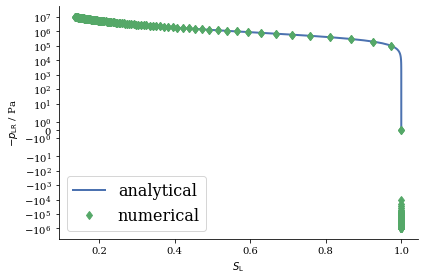

In [12]:
fig, ax = plt.subplots()
ax.plot(saturation(np.logspace(-3,7,100)),np.logspace(-3,7,100),label='analytical')
ax.plot(results[14],-results[7],label='numerical',ls='',marker='d')
ax.legend();
ax.set_xlabel('$S_\\mathrm{L}$')
ax.set_ylabel("$-p_\\mathrm{LR}$ / Pa")
ax.set_yscale('symlog')
fig.tight_layout();

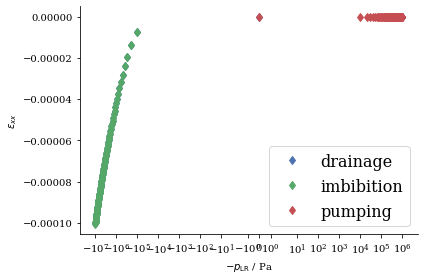

In [13]:
fig, ax = plt.subplots()
ax.plot(results[7][:100],results[1][:100],label='drainage',ls='',marker='d')
ax.plot(results[7][100:200],results[1][100:200],label='imbibition',ls='',marker='d')
ax.plot(results[7][200:],results[1][200:],label='pumping',ls='',marker='d')
ax.legend();
ax.set_ylabel('$\\epsilon_{xx}$')
ax.set_xlabel("$-p_\\mathrm{LR}$ / Pa")
ax.set_xscale('symlog')
fig.tight_layout();

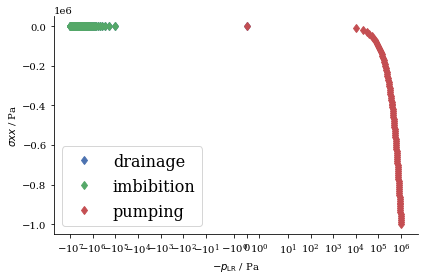

In [14]:
fig, ax = plt.subplots()
ax.plot(results[7][:100],results[8][:100]/1e6,label='drainage',ls='',marker='d')
ax.plot(results[7][100:200],results[8][100:200]/1e6,label='imbibition',ls='',marker='d')
ax.plot(results[7][200:],results[8][200:]/1e6,label='pumping',ls='',marker='d')
ax.legend();
ax.set_ylabel('$\\sigma_{xx}$ / MPa')
ax.set_xlabel("$-p_\\mathrm{LR}$ / Pa")
ax.set_xscale('symlog')
fig.tight_layout();